## Analysis of Citi Bike data from January to April 2020

### Introduction

Citi Bike has been the highlight of my exercise routine and a way to get around without using the subway during the COVID-19 pandemic. I have been living in New York City for almost 3 years now, but I have never jumped onto one of those blue Citi Bikes until recently. They looked heavy and the traffic in Manhattan scared me. But now, with the subway being reserved for essential workers only and the streets being empty more than usual, I had to seize my chance to bike around the city.

After my first trip, I immediately fell in love with the bike sharing service. With so many stations all over Manhattan, it is incredibly convenient. The bikes are heavy but unless you are going up a tough hill, they generally turn out to be okay for the streets of Manhattan. I have biked over Williamsburg Bridge and while the long uphill was tough, it was manageable. I wondered if other New Yorkers are using Citi Bike as a way to exercise as well. I decided to find out using the system data that Citi Bike makes available on the website.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt

print('Libraries imported.')

%autosave 180

Libraries imported.


Autosaving every 180 seconds


I downloaded the Citi Bike system data from the following website: https://www.citibikenyc.com/system-data

Index of data files:
https://s3.amazonaws.com/tripdata/index.html

Sample zip file url:
https://s3.amazonaws.com/tripdata/201903-citibike-tripdata.csv.zip

I did not include trips in Jersey City (JC).

In [210]:
# Load 2020 data and append dataframes
jan_df = pd.read_csv('202001-citibike-tripdata.csv')
feb_df = pd.read_csv('202002-citibike-tripdata.csv')
mar_df = pd.read_csv('202003-citibike-tripdata.csv')
apr_df = pd.read_csv('202004-citibike-tripdata.csv')
df = jan_df.append(feb_df).append(mar_df).append(apr_df)

In [211]:
# We are also going to load the 2019 data for comparison
# Load 2019 data and append dataframes
jan19_df = pd.read_csv('201901-citibike-tripdata.csv') 
feb19_df = pd.read_csv('201902-citibike-tripdata.csv') 
mar19_df = pd.read_csv('201903-citibike-tripdata.csv')
apr19_df = pd.read_csv('201904-citibike-tripdata.csv')
df_2019 = jan19_df.append(feb19_df).append(mar19_df).append(apr19_df)

### First, let's visualize all the Citi Bike stations.

In [212]:
gdf = pd.DataFrame(df.groupby(['start station name'])['start station latitude','start station longitude'].mean())
gdf.reset_index(inplace=True)

In [213]:
from folium.plugins import MarkerCluster

some_map = folium.Map(location=[gdf['start station latitude'].mean(), gdf['start station longitude'].mean()]
                      , zoom_start=12)

mc = MarkerCluster()
for i in range(0,len(gdf)):
    mc.add_child(folium.Marker(location=[gdf.iloc[i]['start station latitude'], gdf.iloc[i]['start station longitude']],
                       popup=gdf.iloc[i]['start station name'])
                      )

some_map.add_child(mc)

some_map

In [15]:
some_map.save('CitiBikeStations.html')

As we can see, most of the stations are in Manhattan, followed by Brooklyn. There are not many stations in Queens.

### Number of daily trips in 2020 are much lower than in 2019, but trending upwards since late March

Next, let's look at how the number of daily trips for the system looks like in 2019 and in 2020.

In [214]:
# Create start date variable
df['startdate'] = pd.to_datetime(df['starttime']).dt.date
df_2019['startdate'] = pd.to_datetime(df_2019['starttime']).dt.date

In [215]:
# Calculate the number of trips each day in 2020
daily_trips = df.groupby(['startdate'])['tripduration'].count()
daily_trips = pd.DataFrame(daily_trips)
daily_trips.rename(columns={"tripduration": "2020_trips"}, inplace=True)
daily_trips.reset_index(inplace=True)

daily_trips['month'] = pd.to_datetime(daily_trips['startdate']).dt.month
daily_trips['day'] = pd.to_datetime(daily_trips['startdate']).dt.day

daily_trips['2020_trips_ra'] = daily_trips['2020_trips'].rolling(window=7).mean() # calculate a weekly average

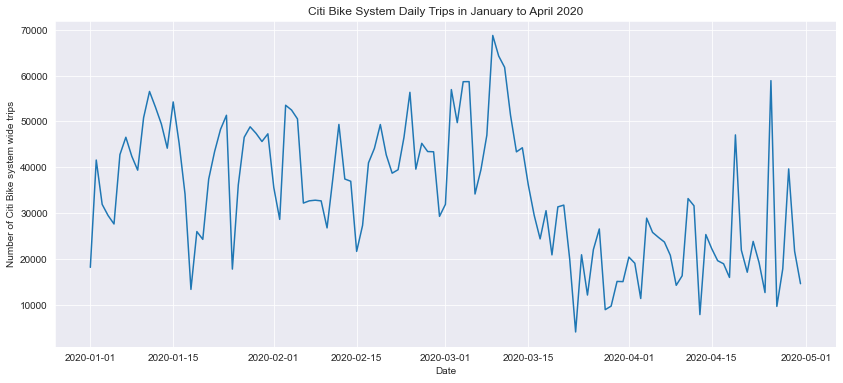

In [216]:
# Chart the data
plt.figure(figsize=(14,6))
sns.set_style("darkgrid", {"xtick.major.size":12})
sns.lineplot(x=daily_trips['startdate'], y=daily_trips['2020_trips'])
plt.title("Citi Bike System Daily Trips in January to April 2020")
plt.xlabel("Date")
plt.ylabel("Number of Citi Bike system wide trips")
plt.show()

We can see that there is a lot of variation depending on the day of the week. Let's do the same to the 2019 data for comparison.

In [217]:
daily_trips_2019 = df_2019.groupby(['startdate'])['tripduration'].count()
daily_trips_2019 = pd.DataFrame(daily_trips_2019)
daily_trips_2019.reset_index(inplace=True)
daily_trips_2019.rename(columns={"tripduration": "2019_trips"}, inplace=True)

daily_trips_2019['month'] = pd.to_datetime(daily_trips_2019['startdate']).dt.month
daily_trips_2019['day'] = pd.to_datetime(daily_trips_2019['startdate']).dt.day

daily_trips_2019['2019_trips_ra'] = daily_trips_2019['2019_trips'].rolling(window=7).mean()

In [218]:
# Merge the 2020 and 2019 daily trips data
daily_trips = pd.merge(daily_trips, daily_trips_2019, how='outer', on=['month','day'], validate='one_to_one')

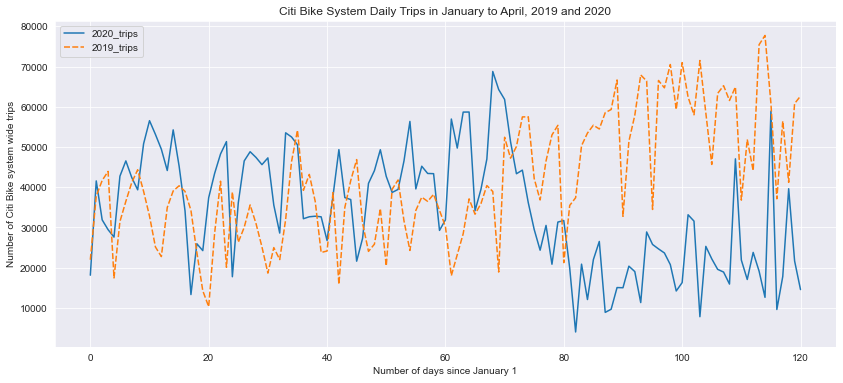

In [219]:
# Plot the daily trips in 2020 and 2019
plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
#x = daily_trips['startdate_x']
y = daily_trips[['2020_trips', '2019_trips']]
sns.lineplot(data=y)
plt.title("Citi Bike System Daily Trips in January to April, 2019 and 2020")
plt.xlabel("Number of days since January 1")
plt.ylabel("Number of Citi Bike system wide trips")
plt.show()

In 2019, the number of daily rides increased as we go from January to April and the weather got warmer. However, in 2020, we see a sharp drop off in mid-March due to the coronavirus pandemic. Now, let's look a 7-day rolling average to remove the effect of the day of the week. 

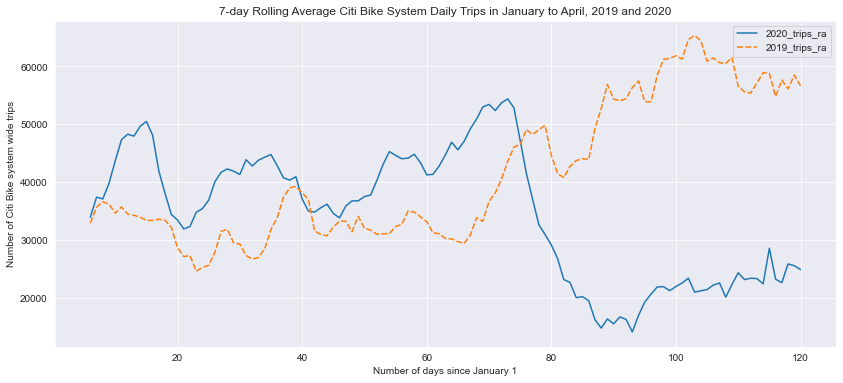

In [64]:
# Plot the 7-day rolling average daily trips
plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
#x = daily_trips['startdate_x']
y = daily_trips[['2020_trips_ra', '2019_trips_ra']]
sns.lineplot(data=y)
plt.title("7-day Rolling Average Citi Bike System Daily Trips in January to April, 2019 and 2020")
plt.xlabel("Number of days since January 1")
plt.ylabel("Number of Citi Bike system wide trips")
plt.show()

We can see the trend clearer on this chart, especially how big the drop in mid-March was.

### Subscriber trips are down but non-subscriber trips are up

People use Citi Bike to commute to work as well as for recreation and exercise. Citi Bike has an annual membership program which gives you unlimited 45-minute rides for a year. Commuters are more likely to be subscribers since they use it more frequently.

In [220]:
# Count number of trips per user type
usertype_2020 = pd.DataFrame(df['usertype'].value_counts())
usertype_2020['Year'] = 2020

usertype_2019 = pd.DataFrame(df_2019['usertype'].value_counts())
usertype_2019['Year'] =  2019

usertype = usertype_2020.append(usertype_2019)
usertype.reset_index(inplace=True)

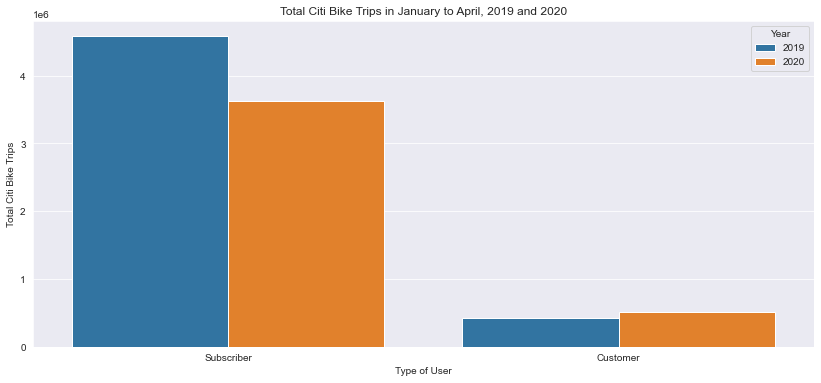

In [221]:
# Chart the data
plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
sns.barplot(x='index',y='usertype',hue='Year',data=usertype)
plt.title("Total Citi Bike Trips in January to April, 2019 and 2020")
plt.xlabel("Type of User")
plt.ylabel("Total Citi Bike Trips")
plt.show()

In the first four months of 2019, subscribers took a total of 4.6 million trips while non-subscribers took a total of 423K trips. In the same period in 2020, subscribers took a total of 3.6 million trips while non-subscribers took a total of 507K trips. Subscriber trips are down by almost a million, but non-subscriber trips are slightly up.

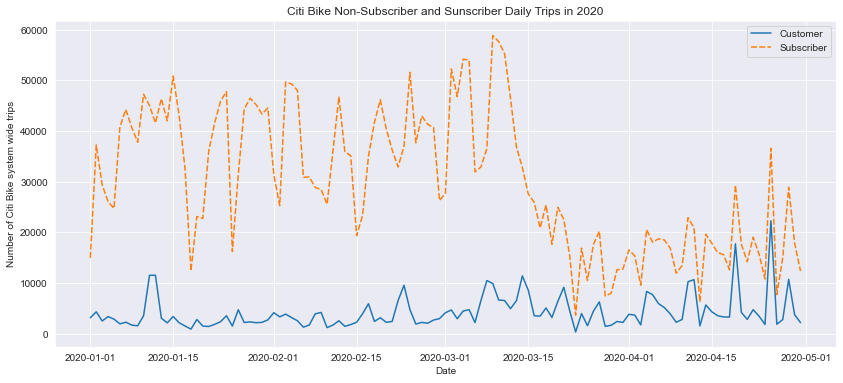

In [222]:
# Analyze daily trips by user type
daily_trips_s = pd.DataFrame(df.groupby(['startdate', 'usertype'])['tripduration'].count())
daily_trips_s.reset_index(inplace=True)
daily_trips_s = pd.pivot(daily_trips_s, index='startdate', columns='usertype', values='tripduration')
daily_trips_s.head()

# Plot the daily trips by user type
plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
#x = daily_trips['startdate_x']
y = daily_trips_s[['Customer', 'Subscriber']]
sns.lineplot(data=y)
plt.title("Citi Bike Non-Subscriber and Sunscriber Daily Trips in 2020")
plt.xlabel("Date")
plt.ylabel("Number of Citi Bike system wide trips")
plt.show()

### Average trip duration is getting longer

The other way to differentiate leisure and commuter trips is by trip average duration. My hypothesis is that longer rides are more likely to be leisure trips.

In [223]:
# Check if there are any outliers in the tripduration column
df['tripduration'].describe()

count    4.138645e+06
mean     1.020477e+03
std      1.184735e+04
min      6.100000e+01
25%      3.480000e+02
50%      6.040000e+02
75%      1.105000e+03
max      3.786187e+06
Name: tripduration, dtype: float64

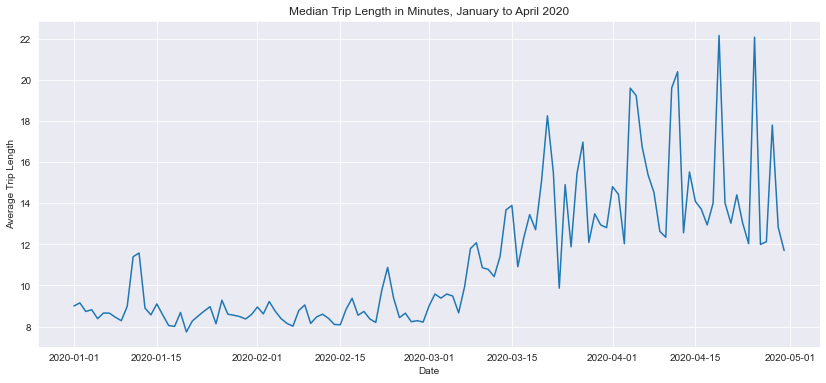

In [224]:
# Use median because there are some outliers
avg_trip_len = df.groupby(['startdate'])['tripduration'].median()/60

# Plot the average trip length
plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
sns.lineplot(data=avg_trip_len)
plt.title("Median Trip Length in Minutes, January to April 2020")
plt.xlabel("Date")
plt.ylabel("Average Trip Length")
plt.show()

Of course, the climbing temperature in NYC also contributes to this, but the upward trend in trip length is remarkable.

### Trips are getting started later in the day

In [225]:
# Create a column for start time and month
starttime = df['starttime']
starttime = pd.to_datetime(starttime)
df['timeonly'] = starttime.dt.time
df['hour'] = starttime.dt.hour
df['month'] = starttime.dt.month
df['month_name'] = starttime.dt.month_name()

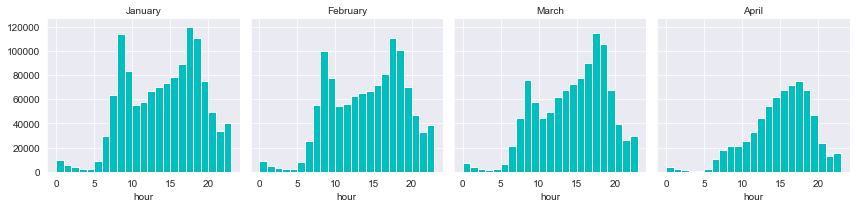

In [226]:
# Create a histogram of trips by start time for each month in 2020
sns.set_style("darkgrid")
g = sns.FacetGrid(df, col="month_name")
bins = df['hour'].unique()
g.map(plt.hist, "hour", bins=bins, color="c").set_titles("{col_name}")

### The busiest stations are no longer in midtown Manhattan

We can also see the purpose of the trips from where the busiest stations are located.

In [227]:
daily_rides_station = pd.DataFrame(df.groupby(['start station name','month_name'])['tripduration'].count())
daily_rides_station.reset_index(inplace=True)

# Make the dataframe wide
daily_rides_station = daily_rides_station.pivot(index='start station name', columns='month_name', values='tripduration')

daily_rides_station.head()

month_name,April,February,January,March
start station name,,,,
1 Ave & E 110 St,520.0,621.0,689.0,790.0
1 Ave & E 16 St,2685.0,4388.0,4835.0,4104.0
1 Ave & E 18 St,2198.0,4119.0,4465.0,3529.0
1 Ave & E 30 St,1802.0,2580.0,2863.0,2286.0
1 Ave & E 44 St,1133.0,2302.0,2507.0,1880.0


In [228]:
# Busiest stations in February
top5feb = pd.DataFrame(daily_rides_station['February'].sort_values(ascending=False).head())
top5feb

,February
start station name,
Pershing Square North,9393.0
W 21 St & 6 Ave,7140.0
8 Ave & W 31 St,6993.0
E 17 St & Broadway,6836.0
Broadway & E 22 St,6284.0


In [229]:
# Busiest stations in April
top5apr = pd.DataFrame(daily_rides_station['April'].sort_values(ascending=False).head())
top5apr

,April
start station name,
1 Ave & E 68 St,4485.0
West St & Chambers St,4372.0
12 Ave & W 40 St,4045.0
Pier 40 - Hudson River Park,3561.0
Broadway & W 60 St,3284.0


In [231]:
station_locations = gdf
station_locations.set_index('start station name', inplace=True)

In [232]:
m = folium.Map(location=[gdf['start station latitude'].mean(), gdf['start station longitude'].mean()]
                      , zoom_start=12)

# Add markers for top 5 stations in February
select_stations = top5feb.index
#select_stations = ['Pershing Square North', '8 Ave & W 31 St', 'W 41 St & 8 Ave', 'W 21 St & 6 Ave', 'E 47 St & Park Ave']
latitudes = station_locations.loc[select_stations]['start station latitude']
longitudes = station_locations.loc[select_stations]['start station longitude']
for lat, lon in zip(latitudes, longitudes): 
    folium.Circle([lat, lon], radius=10, color='red', fill=True, fill_color='red').add_to(m)

# Add markers for top 5 stations in April
select_stations2 = top5apr.index    
latitudes2 = station_locations.loc[select_stations2]['start station latitude']
longitudes2 = station_locations.loc[select_stations2]['start station longitude']    
for lat, lon in zip(latitudes2, longitudes2): 
    folium.Circle([lat, lon], radius=10, color='blue', fill=True, fill_color='red').add_to(m)
    
m

In [209]:
m.save('Busiest Stations in February and April.html')

In February, the stations in mid Manhattan were the busiest. The very top station is Pershing Square North located near Grand Central Terminal, a major commuter hub, where more than 9,000 trips started in February. The other stations in the top five, shown as red dots on the map, are all in mid Manhattan.

However, in April, the stations around the peripherals of Manhattan became the busiest. These include '1 Ave & E 68 St', 'West St & Chambers St', '12 Ave & W 40 St', 'Pier 40 - Hudson River Park', and 'Broadway & W 60 St'. More than 4000 trips were started in West St & Chambers St in the last week of March.

### Conclusion

The data shows a clear trend that usage of Citi Bikes are on the rise since the pandemic began. Even though the curve has flattened in NYC, I expect that many people will continue to opt for Citi Bike rather than the subway or buses, to avoid crowded indoor spaces as well as to enjoy the coming good weather.<br><br>
If you have not tried it yet, I encourage you to try out Citi Bike. Keep a safe distance from others and wear a face covering to keep your respiratory droplets to yourself. Stay safe out there!